In [180]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import gutenberg
from sklearn.model_selection import train_test_split
import spacy
import re
%matplotlib inline

# What I understand of Latent Semantic Analysis:
After cleaning and ignoring stop words, we use tf-idf to identify words that are particular or significant within a small number of sentences. "The tf_idf score will be highest for a term that occurs a lot within a small number of sentences, and lowest for a word that occurs in most or all sentences". Then make each word a one hot encoded dimension for each paragraph (document). 

That's a lot of dimensions! Also, *we have words like aweful and terrible as seperate concepts.* 

Solution to both issues? Shrink it down with Singular Value Decomposition (SVD), which like PCA but not mean-centered, which tries to colapse similar words into single components. **For example, maybe "Emma" and "smart" appear often together, so those could be collapsed into a single component (right?)** "What we get, in the end, is clusters of terms that presumably reflect a topic," with each paragraph (document) scored on each topic.

Document similarity, is just the difference between two document's scores. Also, you can find documents which are highly associated with a given topic.

In [181]:
nlp = spacy.load('en')

In [256]:
NUM_PARAS_TO_PROCESS = 100

In [258]:
def clean_word(word, lemmas=False):
    word = word.text
    if lemmas:
        word = word.lemma_
        word = word if ('-PRON-' not in word) else ''
    return re.sub(r'(volume)|(chapter)|(--)', '', word)

def get_text_paras(file_name='austen-emma.txt', lemmas=False):
    emma=gutenberg.paras(file_name)
    emma_paras=[]
    i = 0
    for paragraph in emma:
        para=nlp(' '.join(paragraph[0]))
        if not (('Oh' in para.text or 'Ah' in para.text) and ('!' in para.text)):
            para = [clean_word(word, lemmas) for word in para]
            #Forming each paragraph into a string and adding it to the list of strings.
            emma_paras.append(' '.join(para))
        i += 1
        if i == NUM_PARAS_TO_PROCESS:
            break
    return emma_paras

In [259]:
get_text_paras()

['[ Emma by Jane Austen 1816 ]',
 'VOLUME I',
 'CHAPTER I',
 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .',
 "She was the youngest of the two daughters of a most affectionate , indulgent father ; and had , in consequence of her sister ' s marriage , been mistress of his house from a very early period .",
 "Sixteen years had Miss Taylor been in Mr . Woodhouse ' s family , less as a governess than a friend , very fond of both daughters , but particularly of Emma .",
 "The real evils , indeed , of Emma ' s situation were the power of having rather too much her own way , and a disposition to think a little too well of herself ; these were the disadvantages which threatened alloy to her many enjoyments .",
 'Sorrow came  a gentle sorrow  but not at all in the shape of any disagreeable cons

# tfidf in sklearn

Happily for us, sklearn has a tfidf function that will do all our heavy lifting.  It also has a [very long list of stop words](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py).  Since we're going to be doing dimension reduction later on anyway, let's keep all the words for now.

In [242]:
def run_tfidf(emma_paras, max_df=0.5, min_df=2):
    from sklearn.feature_extraction.text import TfidfVectorizer

    X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

    vectorizer = TfidfVectorizer(max_df=max_df, # drop words that occur in more than half the paragraphs
                                 min_df=min_df, # only use words that appear at least [twice]
                                 stop_words='english', 
                                 lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                                 use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                                 norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                                 smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                                )


    #Applying the vectorizer
    emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
    print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

    #splitting into training and test sets
    X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


    #Reshapes the vectorizer output into something people can read
    X_train_tfidf_csr = X_train_tfidf.tocsr()

    #number of paragraphs
    n = X_train_tfidf_csr.shape[0]
    #A list of dictionaries, one per paragraph
    tfidf_bypara = [{} for _ in range(0,n)]
    #List of features
    terms = vectorizer.get_feature_names()
    #for each paragraph, lists the feature words and their tf-idf scores
    for i, j in zip(*X_train_tfidf_csr.nonzero()):
        tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]
    
    return X_train_tfidf, X_train, X_test_tfidf, X_test, tfidf_bypara

In [243]:
# Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[100])
print('Tf_idf vector:', tfidf_bypara[100])


Original sentence: " I do think it is , without exception , the best charade I ever read ."
Tf_idf vector: {'exception': 0.5493200758383243, 'charade': 0.5074055444278235, 'read': 0.41206198737738187, 'think': 0.29520136387708074, 'best': 0.42877516379636}


# Dimension reduction
Okay, now we have our vectors, with one vector per paragraph.  It's time to do some dimension reduction.  We use the Singular Value Decomposition (SVD) function from sklearn rather than PCA because we don't want to mean-center our variables (and thus lose sparsity):

In [244]:
def run_dim_reduction(X_data_tfidf, X):
    from sklearn.decomposition import TruncatedSVD
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import Normalizer
    #Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
    svd= TruncatedSVD(130)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    # Run SVD on the training data, then project the training data.
    X_lsa = lsa.fit_transform(X_data_tfidf)

    variance_explained=svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    print("Percent variance captured by all components:",total_variance*100)

    #Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
    paras_by_component=pd.DataFrame(X_lsa,index=X)
    for i in range(5):
        print('\n\nComponent {}:'.format(i))
        print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])
        
    return X_lsa

# Run on training data

In [260]:
emma_paras = get_text_paras('austen-emma.txt')

In [261]:
X_train_tfidf, X_train, X_test_tfidf, X_test, tfidf_bypara = run_tfidf(emma_paras, max_df=0.5, min_df=2)
X_lsa = run_dim_reduction(X_train_tfidf, X_train)

Number of features: 154
Percent variance captured by all components: 99.99999999999999


Component 0:
" They are to be put into Mr . Weston ' s stable , papa .                                                                                                              0.561360
" Emma knows I never flatter her , " said Mr . Knightley , " but I meant no reflection on any body .                                                                   0.532323
" Only one more , papa ; only for Mr . Elton .                                                                                                                         0.456312
Sixteen years had Miss Taylor been in Mr . Woodhouse ' s family , less as a governess than a friend , very fond of both daughters , but particularly of Emma .         0.432171
" I do not understand what you mean by ` success , ' " said Mr . Knightley .                                                                                           0.430267
Mr . Knightley sho

# Sentence similarity

We can also look at how similar various sentences are to one another.  For example, here are the similarity scores (as a heatmap) of the first 10 sentences in the training set:

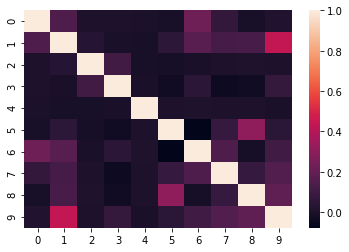

Key:
0 " mr . elton go to be marry ! "
1 emma could not feel a doubt of have give harriet ' s fancy a proper direction and raise the gratitude of  young vanity to a very good purpose , for  find  decidedly more sensible than before of mr . elton ' s be a remarkably handsome man , with most agreeable manner ; and as  have no hesitation in follow up the assurance of  admiration by agreeable hint ,  be soon pretty confident of create as much liking on harriet ' s side , as there could be any occasion for .
2  now walk on together quietly , till within view of the vicarage pale , when a sudden resolution , of at least get harriet into the house , make  again find something very much amiss about  boot , and fall behind to arrange  once more .
3 " but  be very much , and without be at all ashamed of  .
4 " thank  .
5 while  talk to isabella , however , emma find an opportunity of say ,
6 real , long - stand regard bring the westons and mr . knightley ; and by mr . elton , a young man live al

In [246]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_lsa) * np.asmatrix(X_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


# Drill 0: Test set

Now it's your turn: Apply our LSA model to the test set.  Does it identify similar sentences for components 0 through 4?  

In [247]:
# Remember, you will use the same model, only with the test set data.  Don't fit a new model by mistake!
X_tes_lsa = run_dim_reduction(X_test_tfidf, X_test)

Percent variance captured by all components: 70.18651235041786


Component 0:
"  do not know what  opinion may be , mrs . weston , " say mr . knightley , " of this great intimacy between emma and harriet smith , but  think  a bad thing . "                                                                                                                                                                        0.542234
" emma never think of  , if  can do good to other , " rejoin mr . woodhouse , understanding but in part .                                                                                                                                                                                                                                0.471503
" emma know  never flat  , " say mr . knightley , " but  mean no reflection on any body .                                                                                                                                                             

# Drill 1: Tweaking tf-idf

Go back up to the code where we originally translated the text from words to numbers.  There are a lot of decision-points here, from the stop list to the thresholds for inclusion and exclusion, and many others as well.  We also didn't integrate spaCy, and so don't have info on lemmas or Named Entities.  Change things up a few times and see how that affects the results of the LSA.  Write up your observations and share them with your mentor.

# Improvement ideas:
- Collapse words into lemmas
- Expand stop-list?
- Change threshold for inclusion

In [172]:
#Tweaks Go Here
